I am trying to determine if Mie scattering is a possible explanation for the large-scale changes in wavelength-dependence of the transmission (the small-scale oscillations are thought to be due to thin film interference). Mie scattering could result if there are impurities in the Krypton film. The impurities are modelled as spheres of a constant radius. According to the paper, "Rayleigh, Mie, and Tyndall scatterings of polystyrene microspheres
in water: Wavelength, size, and angle dependences", the formula for the scattering cross-section of a dielectric sphere is 
$$\sigma_s=\frac{\lambda_1^2}{2\pi}\sum_{n=1}^{\infty}(2n+1)(|a_n|^2+|b_n|^2),$$where 
$$a_n=(-1)^{n+1/2}\frac{S_n(\alpha)S_n'(\beta)-mS_n(\beta)S_n'(\alpha)}{S_n'(\beta)\phi_n(\alpha)-mS_n(\beta)\phi_n'(\alpha)},$$
$$b_n=(-1)^{n+3/2}\frac{mS_n(\alpha)S_n'(\beta)-S_n(\beta)S_n'(\alpha)}{mS_n'(\beta)\phi_n(\alpha)-S_n(\beta)\phi_n'(\alpha)},$$
$$S_n(z)=\sqrt{\frac{\pi z}{2}}J_{n+1/2}(z),$$
$$C_n(z)=(-1)^n\sqrt{\frac{\pi z}{2}}J_{-n-1/2}(z),$$
$$\phi_n(z)=S_n(z)+iC_n(z),$$
$J_k(z)$ is a Bessel function, $\alpha=2\pi r/\lambda_1$, $\beta=m\alpha$, $m$ is the ratio of the refractive index of the sphere to that of the surrounding medium, $r$ is the radius of the sphere, and $\lambda_1$ is the wavelength of the scattered light in the surrounding medium.
<br>
The derivatives of $S_n(z)$, $C_n(z)$, and $\phi_n(z)$ (with respect to z) can be determined via the product rule and linearity of the derivative:
$$S_n'(z)=\sqrt{\frac{\pi z}{2}}J_{n+1/2}'(z)+\frac{1}{2}\sqrt{\frac{\pi}{2z}}J_{n+1/2}(z)$$
$$C_n'(z)=(-1)^n\left[\sqrt{\frac{\pi z}{2}}J_{-n-1/2}'(z)+\frac{1}{2}\sqrt{\frac{\pi}{2z}}J_{-n-1/2}(z)\right]$$
$$\phi_n'(z)=S_n'(z)+iC_n'(z)$$

In [1]:
#This cell imports important modules and defines a function that calculates a single term of the infinite series
#  above, as well as all prerequisite functions.
#scipy.special contains the Bessel functions and their derivatives

import scipy.special as fn
import matplotlib.pyplot as plt
import numpy as np

#Define functions for S_n(z), C_n(z), Φ_n(z), and their derivatives (derivatives denoted with a "d")

def S(n,z):
    return np.sqrt(np.pi/2*z)*fn.jv(n+1/2,z)  # fn.jv(k,z) is the Bessel function J_k(z)

def dS(n,z):
    v = n+1/2
    s = np.sqrt(np.pi/2*z)*fn.jvp(v,z)    # fn.jvp(k,z) is the derivative of the Bessel function (wrt z)
    t = np.sqrt(np.pi/(2*z))/2*fn.jv(v,z)
    return s+t

def C(n,z):
    v = n+1/2
    return (-1)**n*np.sqrt(np.pi/2*z)*fn.jv(-v,z)

def dC(n,z):
    v = n+1/2
    s = np.sqrt(np.pi/2*z)*fn.jvp(-v,z)
    t = 0.5*np.sqrt(np.pi/(2*z))*fn.jv(-v,z)
    return (-1)**n*(s+t)

def phi(n,z):
    return S(n,z)+1j*C(n,z)

def dphi(n,z):
    return dS(n,z)+1j*dC(n,z)

#Now I define functions for a_n and b_n and a function for the nth term in the infinite series in the expression
# for the cross section.
#l is λ₀, r & m represent the same things as above.

def a_n(n,l,r,m):
    alpha = 2*np.pi*r/l
    beta = m*alpha
    top = S(n,alpha)*dS(n,beta)-m*S(n,beta)*dS(n,alpha)
    bot = dS(n,beta)*phi(n,alpha)-m*S(n,beta)*dphi(n,alpha)
    return (-1)**(n+1/2)*top/bot

def b_n(n,l,r,m):
    alpha = 2*np.pi*r/l
    beta = m*alpha
    top = m*S(n,alpha)*dS(n,beta)-S(n,beta)*dS(n,alpha)
    bot = m*dS(n,beta)*phi(n,alpha)-S(n,beta)*dphi(n,alpha)
    return (-1)**(n+3/2)*top/bot

def term(n,l,r,m):
    return (2*n+1)*(abs(a_n(n,l,r,m))**2+abs(b_n(n,l,r,m))**2)

In [2]:
#This function calculates the cross section. l is λ₀, r & m represent the same things as above.
def cs(l,r,m):
    total = 0  #I use a while loop to add up the infinite sum
    nterm = 1
    n=1
    while np.all(abs(nterm) >= 1e-35): #By the time the terms get this small, the sum has already converged to the answer.
        nterm = term(n,l,r,m)
        n+=1
        total+=nterm
    return l**2/2/np.pi*total       

In [3]:
#Refractive index values for polystrene, based on wavelength. Not very important here
def ind(lam):
    A = 1.5663
    B = 0.00785
    C = 0.000334
    return A + B/(lam*1e6)**2 + C/(lam*1e6)**4

Transmission is calculated based on the formula $$T=e^{-(K_1+K_2^a+K_2^s)l},$$ where $T$ is the transmission, $l$ is the path length, $K_1$ is the extinction coefficient of the surrounding medium, $K_2^a$ is the extinction caused by absorbance by the spheres (impurities), and $K_2^s$ is the extinction due to scattering. All three extinction coefficients are functions of $\lambda_0$, the wavelength of light. $K_2^s$ can be determined from the scattering cross section by $$K_2^s=\sigma_sN_s,$$ where $N_s$ is the number of spheres per unit volume.

In [4]:
#function for transmission. lam = λ₀, Ka & Ks are K_2^a & K_2^s, other variable names are the same as above
def trans(lam,K1,Ka,l,Ns,r,m):
    Ks = cs(lam,r,m)*Ns
    T = np.exp(-(K1+Ka+Ks)*l)
    return T

The next two cells are a test to make sure the infinite sum in the cross section expression converges quickly.

In [131]:
lam = 600e-9
r = 1e-6
m = 1/1.5
arr = np.arange(1,100,1)

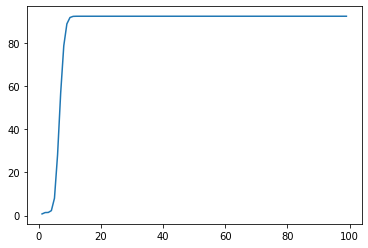

In [132]:
terms = []
t=0
for k in range(1,100):
    t += term(k,lam,r,m)
    terms.append(t)

plt.plot(arr,terms)

Reproduction of Figure 2a from the aforementioned paper. It is a graph of $\frac{\sigma_s}{\pi r^2}$, the ratio of scattering cross section to the cross sectional area of the spheres, against $\delta=\frac{\lambda_1}{2r}$, the ratio of the wavelength of light to the diameter of the spheres. The ability to reproduce the graph shows that everything has been calculated correctly.

In [90]:
#The graph uses values of δ from .001 to 100 on a logarithmic scale, which I reproduced in the delta array.
init = np.linspace(-3,2,2000)
delta = np.exp(init*np.log(10))
r = 1e-3 #This value is arbitrary. The paper did not state what value of r was used.

# I calculate the cross section for each value of δ, stored as a list, and turn the list into an array.
sig = []
for i in delta:
    lam = i*2*r
    m = ind(lam)/1.333 #m is calculated for each wavelength based on the refractive indices of polystrene and water
    # n for water is approximately 1.333. Technically, it should vary with wavelength as well, but the difference
    #    is negligible.
    # The original graph from the paper used a constant value of both refractive indices, based on the refractive 
    #    index for 500 nm light. I have slighly changed this by using the ind() function, rather than a constant,
    #    but the refractive index varies so little that it has no effect. 
    sig.append(cs(lam,r,m))
sig=np.array(sig)

Text(0, 0.5, 'Cross section/πr^2')

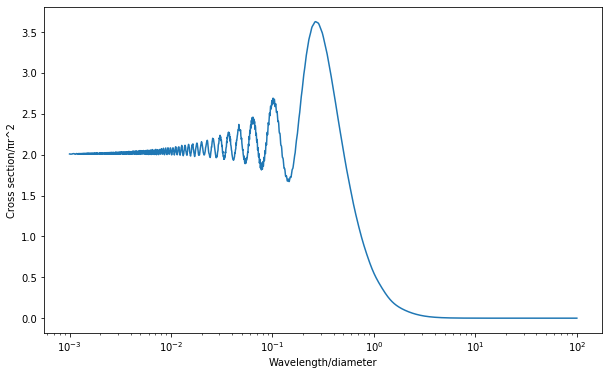

In [91]:
plt.figure(figsize=(10,6))
plt.plot(delta,sig/(np.pi*r**2))
plt.xlabel("Wavelength/diameter")
plt.xscale('log')
plt.ylabel("Cross section/πr^2")

This code (the next 3 cells) was used to see how the graph changes when the value of $m$ is changed.

In [146]:
r=1e-6
mlist = 0.5 + 1.5*np.arange(51)/50
lam = np.linspace(200e-9,850e-9,650)
sigs = np.zeros((len(mlist),len(lam)))
for i in range(51):
    for j in range(len(lam)):
        sigs[i,j]=cs(lam[j],r,mlist[i])


In [191]:
from time import sleep
from IPython.display import clear_output

In [ ]:
for i in range(51):
    plt.plot(lam*1e9,sigs[i]*1e12,label='m={:.2f}'.format(0.5+1.5*i/50))
    plt.xlabel("Wavelength (nm)")
    plt.ylabel("Cross section (μm^2)")
    plt.legend(loc='upper right')
    plt.show()
    sleep(0.5)
    clear_output(wait=True)

There are 3 possibilities for the cause of the Mie scattering. One possibility is that there are small bubbles or gaps in the film, which are causing scattering because their refractive index is 1, which is much lower than solid 
krypton's refractive index. Another possibility is that there are impurities in the film due to some other material, which could have any refractive index. A third is that the film is has large amounts of vacuum with small krypton bubbles in it.

In [190]:
#Model 1: Vacuum impurities (Bubble model)
lam = np.linspace(200e-9,850e-9,650)
r = .25e-6
l = 100e-6
Ns = 5e15
n1 = 1.37
n2 = 1
m = n2/n1
K1 = 0
K2a = 0

In [34]:
4*np.pi/3*.25e-6**3

6.544984694978735e-20

In [35]:
1/5e15

2e-16

Text(0, 0.5, 'Transmission')

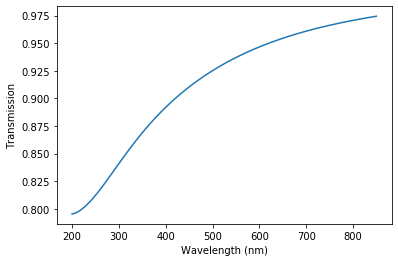

In [93]:
Ts = []
for i in lam:
    Ts.append(trans(i,K1,K2a,l,Ns,r,m))
Ts = np.array(Ts)
plt.plot(lam*1e9,Ts)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [196]:
#Varying r

rlist = 125e-9*np.exp(np.log(2)*np.array(range(5)))
sigs = np.zeros((len(rlist),len(lam)))
for i in range(5):
    for j in range(len(lam)):
        sigs[i,j]=trans(lam[j],K1,K2a,l,Ns,rlist[i],m)

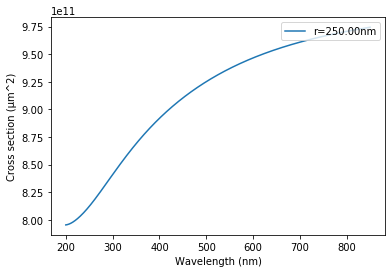

KeyboardInterrupt: 

In [201]:
while j==j: #This will play a loop that repeats the animation.
    for i in range(5): #plots different values of r
        plt.plot(lam*1e9,sigs[i]*1e12,label='r={:.2f}nm'.format(125*2**i))
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Cross section (μm^2)")
        plt.legend(loc='upper right')
        plt.show()
        sleep(1)
        clear_output(wait=True)

In [94]:
#Model 2: Impurities with higher refractive index 
lam = np.linspace(200e-9,850e-9,650)
r = .5e-6
l = 100e-6
Ns = 1e15
n1 = 1.37
n2 = 1.5
m = n2/n1
K1 = 0
K2a = 0

In [7]:
print(4*np.pi/3*.5e-6**3)
print(1/1e15)

5.235987755982988e-19
1e-15


Text(0, 0.5, 'Transmission')

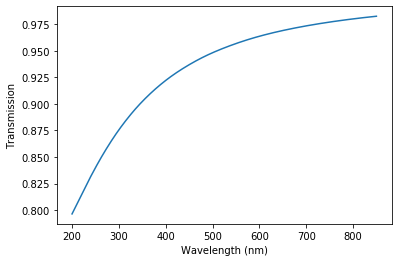

In [95]:
Ts = []
for i in lam:
    Ts.append(trans(i,K1,K2a,l,Ns,r,m))
Ts = np.array(Ts)
plt.plot(lam*1e9,Ts)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

Text(0, 0.5, 'Transmission')

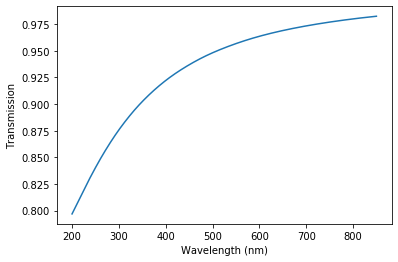

In [96]:
#Test to ensure that the smooth function (defined below) works properly
T = smooth(trans,200e-9,850e-9,650,K1,K2a,l,Ns,r,m)
plt.plot(lam*1e9,T)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [188]:
#Model 3: Vacuum with krypton spheres (dot model)
lam = np.linspace(200e-9,850e-9,650)
r = .5e-6
l = 100e-6
Ns = 1e15
n1 = 1
n2 = 1.37
m = n2/n1
K1 = 0
K2a = 0

Text(0, 0.5, 'Transmission')

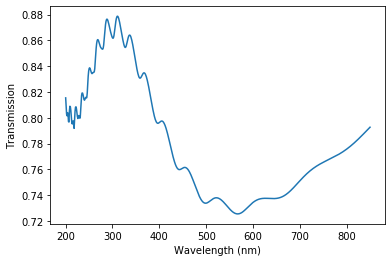

In [189]:
Ts = []
for i in lam:
    Ts.append(trans(i,K1,K2a,l,Ns,r,m))
Ts = np.array(Ts)
plt.plot(lam*1e9,Ts)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [87]:
#loading in this data. I don't have the full data for this experiment, so I can't do much with it.
arr = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190814_film_gc_FLMS138901_21-49-33-532.txt",skiprows=14)
arr = arr[arr[:,1]<15000]
lamda = arr[:,0]
count = arr[:,1]

Text(0, 0.5, 'Adjusted photon count')

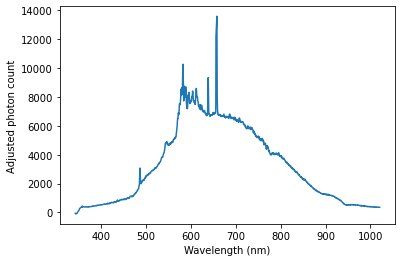

In [88]:
plt.plot(lamda,count)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Adjusted photon count")

These are functions that define the three models used above.

In [5]:
#transmission of a nonabsorbing sample of solid Kr with path length 100 microns and imperfections caused by spheres
#of vacuum. variables are wavelength of light, density of spheres, and size of spheres
def Model1(wl,r,Ns):
    return trans(wl,0,0,100e-6,Ns,r,1/1.37)

In [6]:
def Model2(wl,r,Ns,m):
    return trans(wl,0,0,100e-6,Ns,r,m)

In [7]:
def Model3(wl,r,Ns):
    return trans(wl,0,0,100e-6,Ns,r,1.37)

In [8]:
#This function will calculate an array of smoothed out values of the chosen function. It calculates 10 times as many
#values as you want from the specified interval, and then averages every ten of them.
def smooth(func,start,end,num,*args):
    many = np.linspace(start,end,10*num)
    arr = []
    for i in many:
        arr.append(func(i,*args))
    arr = np.array(arr)
    newarr = np.zeros(num)
    for i in range(num):
        newarr[i]=sum(arr[10*i:10*i+10])/10
    return newarr

This data is not very good data because it is from an experiment where the film was clean, so there isn't much scattering. In fact, the transmission for nearly all of the data is greater than 1, making it impossible to fit the model to it. I ended up fitting data to the reciprocal of the transmission because I thought I must have gotten the formula flipped when all the data showed the transmission greater than 1.

In [118]:
arr1 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190831_kr_34K_dark_FLMS138901_14-46-32-481.txt",skiprows=14)
arr2 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190831_kr_34K_film_FLMS138901_16-06-32-354.txt",skiprows=14)
arr3 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190831_kr_34K_nofilm_FLMS138901_14-45-14-487.txt",skiprows=14)
wavl = arr1[:,0]*1e-9
dark = arr1[:,1]
film = arr2[:,1]
nofilm = arr3[:,1]
tr = (nofilm-dark)/(film-dark)

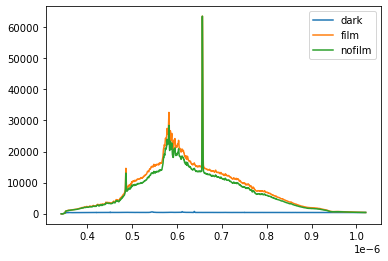

In [119]:
plt.plot(wavl,dark,label='dark')
plt.plot(wavl,film,label='film')
plt.plot(wavl,nofilm,label='nofilm')
plt.legend()

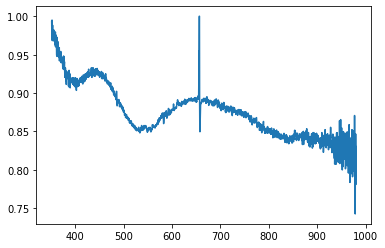

In [169]:
plt.plot(wavl[24:1900]*1e9,tr[24:1900])
#I cut out the beginning of the data because it produced a large spike that made it impossible to see the variation
#in the rest of the data.
#The end of the data is too noisy

In [9]:
from scipy.optimize import curve_fit

In [121]:
popt = curve_fit(Model1,wavl[24:1900],tr[24:1900],[1e-6,1e14])[0]

Text(0, 0.5, 'Transmission')

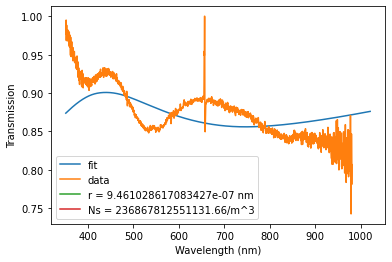

In [122]:
plt.plot(wavl[24:]*1e9,Model1(wavl[24:],*popt),label='fit')
plt.plot(wavl[24:1900]*1e9,tr[24:1900],label='data')
plt.plot([],[],label='r = {} m'.format(popt[0]))
plt.plot([],[],label='Ns = {}/m^3'.format(popt[1]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [126]:
popt = curve_fit(Model1,wavl[24:1900],tr[24:1900],[1e-6,1e12])[0]

Text(0, 0.5, 'Transmission')

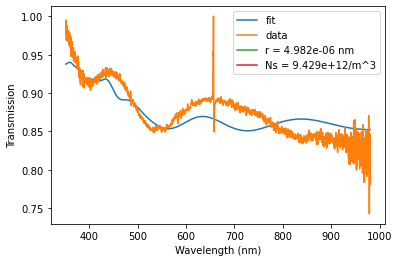

In [125]:
modelfit = Model1(wavl[24:1900],*popt)
plt.plot(wavl[24:1900]*1e9,modelfit,label='fit')
plt.plot(wavl[24:1900]*1e9,tr[24:1900],label='data')
plt.plot([],[],label='r = {:.3e} m'.format(popt[0]))
plt.plot([],[],label='Ns = {:.3e}/m^3'.format(popt[1]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

This is a better fit from the previous one, but it looks like the parameters never vary much from their initial values, suggesting that the curve fit is getting stuck in a local minimum. To see how good the fit is, I will calculate the correlation.

In [223]:
corr = np.corrcoef(tr[24:1900],modelfit)[0,1]
print(corr,corr**2)

0.7920967485130037 0.6274172590048727


In [127]:
popt = curve_fit(Model3,wavl[24:1900],tr[24:1900],[1e-6,1e14])[0]

Text(0, 0.5, 'Transmission')

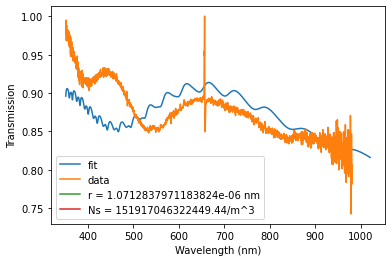

In [128]:
plt.plot(wavl[24:]*1e9,Model3(wavl[24:],*popt),label='fit')
plt.plot(wavl[24:1900]*1e9,tr[24:1900],label='data')
plt.plot([],[],label='r = {} m'.format(popt[0]))
plt.plot([],[],label='Ns = {}/m^3'.format(popt[1]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [129]:
popt = curve_fit(Model2,wavl[24:1900],tr[24:1900],[1e-6,1e14,1.3])[0]

Text(0, 0.5, 'Transmission')

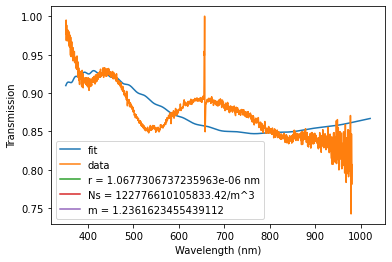

In [130]:
plt.plot(wavl[24:]*1e9,Model2(wavl[24:],*popt),label='fit')
plt.plot(wavl[24:1900]*1e9,tr[24:1900],label='data')
plt.plot([],[],label='r = {} m'.format(popt[0]))
plt.plot([],[],label='Ns = {}/m^3'.format(popt[1]))
plt.plot([],[],label='m = {}'.format(popt[2]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

I am going to cut out the noise from the data to make it easier to analyze without having to include a mask in every line of code. As before, I will cut out the beginning and end of the data because they are quite noisy. I also cut out a small section in the middle where there was a large, sudden peak.

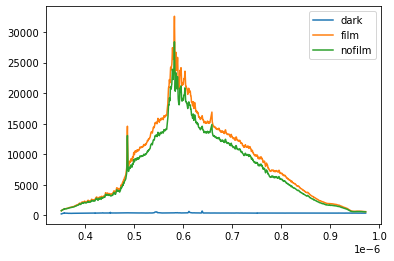

In [134]:
#This is an array of indices that I will convert into an array of indices to keep.
indices = np.array(range(len(arr1[:,0])))
keep = (((indices>=24)*(indices<855))+((indices>865)*(indices<1870)))!=0
wavl = arr1[:,0][keep]*1e-9
dark = arr1[:,1][keep]
film = arr2[:,1][keep]
nofilm = arr3[:,1][keep]
tr = (nofilm-dark)/(film-dark)
plt.plot(wavl,dark,label='dark')
plt.plot(wavl,film,label='film')
plt.plot(wavl,nofilm,label='nofilm')
plt.legend()

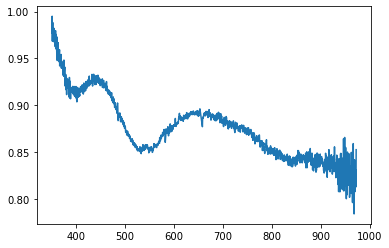

In [135]:
plt.plot(wavl*1e9,tr)

In [138]:
popt = curve_fit(Model1,wavl,tr,[1e-6,1e12])[0]

Text(0, 0.5, 'Transmission')

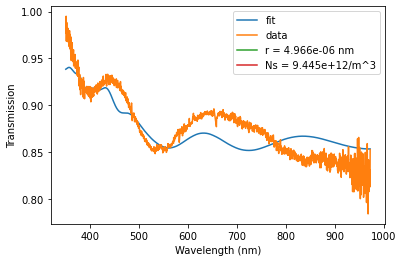

In [137]:
modelfit = Model1(wavl,*popt)
plt.plot(wavl*1e9,modelfit,label='fit')
plt.plot(wavl*1e9,tr,label='data')
plt.plot([],[],label='r = {:.3e} m'.format(popt[0]))
plt.plot([],[],label='Ns = {:.3e}/m^3'.format(popt[1]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [83]:
corr = np.corrcoef(tr,modelfit)[0,1]
print(corr,corr**2)

0.8074989367662642 0.6520545328786471


The fit is slightly better than last time.

In [110]:
plt.figure(figsize=(50,35))
coeffs = np.zeros((10,10,len(tr)))
rarray = np.zeros((10,10))
for i in range(10):
    for j in range(10):
        popt = curve_fit(Model1,wavl,tr,[10**(-4+j*5/2),10**(12+i/2)])[0]
        coeffs[i,j] = popt
        plt.subplot(10,10,10*i+j+1)
        modelfit = Model1(wavl,*popt)
        rarray[i,j] = np.corrcoef(tr,modelfit)[0,1]
        plt.plot(wavl*1e9,modelfit,label='fit')
        plt.plot(wavl*1e9,tr,label='data')
        plt.plot([],[],label='r = {:.3e} m'.format(popt[0]))
        plt.plot([],[],label='Ns = {:.3e}/m^3'.format(popt[1]))
        plt.legend()
        plt.xlabel("Wavelength (nm)")
        plt.ylabel("Transmission")

<Figure size 3600x2520 with 0 Axes>

This time, I am using one of the dirty films so that scattering will have a greater effect.

Text(0, 0.5, 'Transmission')

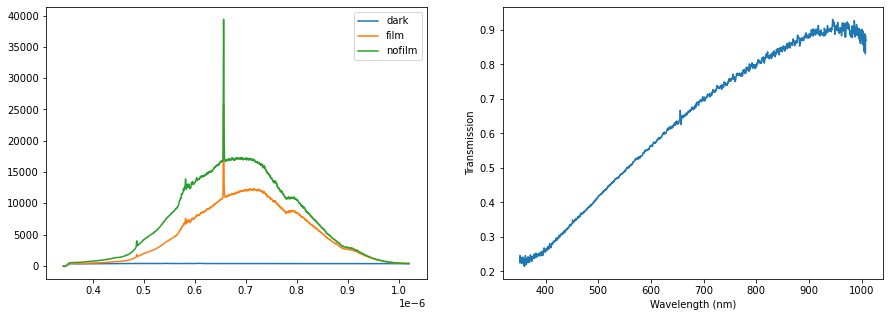

In [16]:
arr1 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190722_Ar_28K_dark_FLMS138901_15-00-14-000.txt",skiprows=14)
arr2 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190722_Ar_28K_film_FLMS138901_14-58-43-415.txt",skiprows=14)
arr3 = np.loadtxt(r"C:\Users\jrnoo\OneDrive\Documents\Mie Model\190722_Ar_28K_no_film_FLMS138901_13-45-49-884.txt",skiprows=14)
wavl = arr1[:,0]*1e-9
dark = arr1[:,1]
film = arr2[:,1]
nofilm = arr3[:,1]
tr = ((film-dark)/(nofilm-dark))[24:2000]
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(wavl,dark,label='dark')
plt.plot(wavl,film,label='film')
plt.plot(wavl,nofilm,label='nofilm')
plt.legend()
plt.subplot(1,2,2)
wavl = wavl[24:2000]
plt.plot(wavl*1e9,tr)
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [141]:
popt = curve_fit(Model1,wavl,tr,[1e-6,1e15])[0]

Text(0, 0.5, 'Transmission')

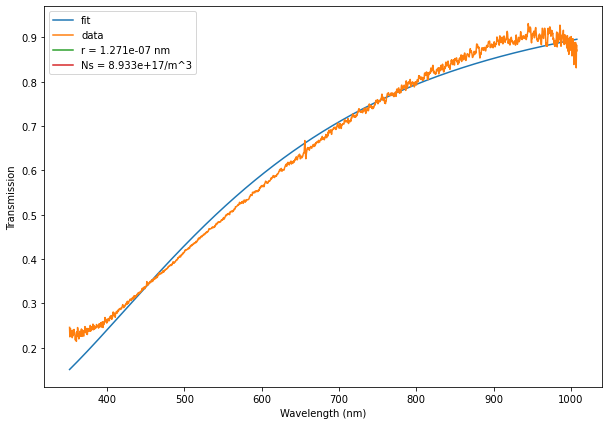

In [142]:
modelfit = Model1(wavl,*popt)
plt.figure(figsize=(10,7))
plt.plot(wavl*1e9,modelfit,label='fit')
plt.plot(wavl*1e9,tr,label='data')
plt.plot([],[],label='r = {:.3e} m'.format(popt[0]))
plt.plot([],[],label='Ns = {:.3e}/m^3'.format(popt[1]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [143]:
corr = np.corrcoef(tr,modelfit)[0,1]
MSE = sum((modelfit-tr)**2)/len(tr)
print(corr,corr**2,MSE,MSE**0.5)

0.9944237517875573 0.9888785981192413 0.0005538980769118742 0.023535039343750293


The data here correlates very strongly with the Mie scattering model, and the mean squared error is low. Also, the best fit was very far from the initial guess, indicating that the curve_fit function likely did not get stuck in a local minimum. However, it doesn't appear to be a perfect fit.

Text(0, 0.5, 'Transmission')

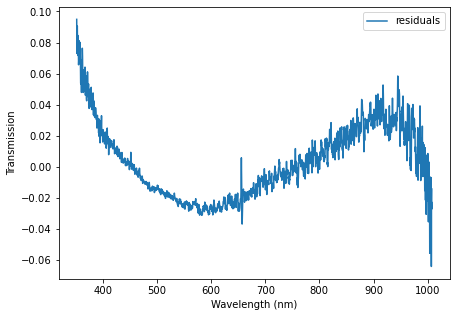

In [144]:
plt.figure(figsize=(7,5))
res = tr-modelfit
plt.plot(wavl*1e9,res,label='residuals')
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

There is a clear pattern in the residuals. This could be caused by something other than Mie scattering, or it could mean that the model used is not perfect. One idea I has was that it may be caused by Mie scattering from differently-sized bubbles. Model 1 assumes that all bubbles are the same size, but this might not be the case. What if we allow for two sizes of bubbles?

In [10]:
def doublebubble(wl,r1,Ns1,r2,Ns2):
    return trans(wl,0,0,100e-6,Ns1,r1,1/1.37)*trans(wl,0,0,100e-6,Ns2,r2,1/1.37)

In [163]:
popt = curve_fit(doublebubble,wavl,tr,[1e-6,1e14,1e-7,1e16])[0]

Text(0, 0.5, 'Transmission')

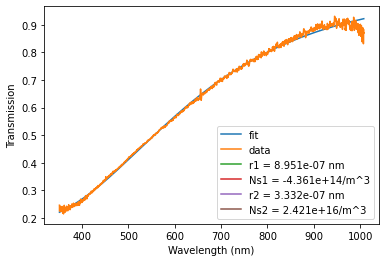

In [162]:
modelfit = doublebubble(wavl,*popt)
plt.plot(wavl*1e9,modelfit,label='fit')
plt.plot(wavl*1e9,tr,label='data')
plt.plot([],[],label='r1 = {:.3e} m'.format(popt[0]))
plt.plot([],[],label='Ns1 = {:.3e}/m^3'.format(popt[1]))
plt.plot([],[],label='r2 = {:.3e} nm'.format(popt[2]))
plt.plot([],[],label='Ns2 = {:.3e}/m^3'.format(popt[3]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [164]:
corr = np.corrcoef(tr,modelfit)[0,1]
MSE = sum((modelfit-tr)**2)/len(tr)
print(corr,corr**2,MSE,MSE**0.5)

0.9987452607946369 0.9974920959597472 0.00012076142421840176 0.010989150295559786


Although this is a very good fit, it cannot correspond to reality because Ns1 is negative. There can't be a negative number density of spheres. The doublebubble model also gets stuck in local minima a lot, as I had to do a lot of messing around with the initial guesses to get a good fit at all.

The dirty films are argon, not krypton, so I need to change the models to make them work. Solid argon's refractive index is a bit smaller. Maybe this will improve the fit.

In [11]:
def Model1A(wl,r,Ns):
    return trans(wl,0,0,100e-6,Ns,r,1/1.29)

def Model3A(wl,r,Ns):
    return trans(wl,0,0,100e-6,Ns,r,1.29)

In [168]:
popt = curve_fit(Model1A,wavl,tr,[1e-6,1e15])[0]

Text(0, 0.5, 'Transmission')

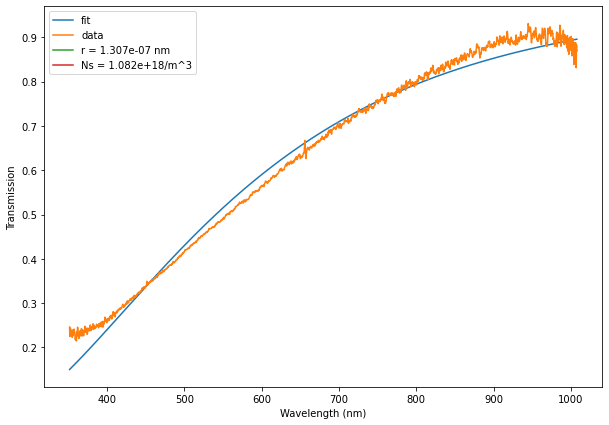

In [169]:
modelfit = Model1A(wavl,*popt)
plt.figure(figsize=(10,7))
plt.plot(wavl*1e9,modelfit,label='fit')
plt.plot(wavl*1e9,tr,label='data')
plt.plot([],[],label='r = {:.3e} m'.format(popt[0]))
plt.plot([],[],label='Ns = {:.3e}/m^3'.format(popt[1]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [170]:
corr = np.corrcoef(tr,modelfit)[0,1]
MSE = sum((modelfit-tr)**2)/len(tr)
print(corr,corr**2,MSE,MSE**0.5)

0.9943784977974646 0.9887885968819422 0.0005572812540224816 0.023606805248116095


Text(0, 0.5, 'Transmission')

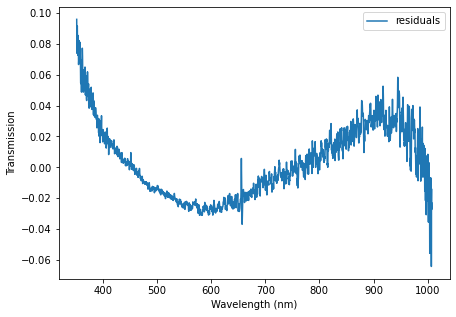

In [171]:
plt.figure(figsize=(7,5))
res = tr-modelfit
plt.plot(wavl*1e9,res,label='residuals')
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

Unfortunately, the fit doesn't seem to have improved at all. The slight difference in refractive index made basically no difference.

In [12]:
def doublebubbleA(wl,r1,Ns1,r2,Ns2):
    return Model1A(wl,r1,Ns1)*Model1A(wl,r2,Ns2)

In [17]:
popt = curve_fit(doublebubbleA,wavl,tr,[1e-6,1e14,1e-7,1e16])[0]

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in tr

Text(0, 0.5, 'Transmission')

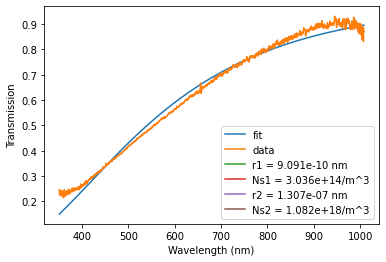

In [18]:
modelfit = doublebubbleA(wavl,*popt)
plt.plot(wavl*1e9,modelfit,label='fit')
plt.plot(wavl*1e9,tr,label='data')
plt.plot([],[],label='r1 = {:.3e} m'.format(popt[0]))
plt.plot([],[],label='Ns1 = {:.3e}/m^3'.format(popt[1]))
plt.plot([],[],label='r2 = {:.3e} m'.format(popt[2]))
plt.plot([],[],label='Ns2 = {:.3e}/m^3'.format(popt[3]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

In [19]:
corr = np.corrcoef(tr,modelfit)[0,1]
MSE = sum((modelfit-tr)**2)/len(tr)
print(corr,corr**2,MSE,MSE**0.5)

0.9943785001604915 0.9887886015814285 0.0005572812540225292 0.023606805248117105


The doublebubble model has not improved the fit at all. It is indistinguishable from the fit with the single bubble size model.

One of the assumptions of the bubble model is that the bubbles all have the same size. This obviously is not true in real life, so perhaps using a distribution of different sizes will fix the model. To do this, I assume that the sizes of the bubbles follow a normal distribution and approximate the average cross section by taking values equal to the mean, $\pm1\sigma$ from the mean, and $\pm2\sigma$ from the mean, calculating the cross section for those values, and multiplying by a probability weighting.

In [13]:
from scipy.stats import norm
# norm.cdf is the cdf for a normal distribution with σ = 1 and μ = 0 as defaults.

In [47]:
def avecs(l,r,m,σ):
    rs = [r-2*σ,r-σ,r,r+σ,r+2*σ] # different values for radius
    prob0 = [norm.cdf(.5)-norm.cdf(-.5)] # probability that a variable is within half a std dev of the mean
    prob1 = [norm.cdf(1.5)-norm.cdf(.5)] # prob of being between .5 and 1.5 std dev above the mean (or below it)
    prob2 = [(1-prob0[0]-2*prob1[0])/2] # probability of being above 1.5 std dev from the mean (or below)
    # Note that the values of prob0, prob1, and prob2 are singleton lists so that the resulting probs array is 
    #vertical. This is necessary for reshaping the array when l is an array input.
    prbs = np.array([prob2,prob1,prob0,prob1,prob2]) #prob weightings to multiply each element in rs by
    secs = [] # cross sections for each value of rs
    for i in rs:
        secs.append(cs(l,i,m))
    secs = np.array(secs)
    # reshaping prbs so that it is the same shape as secs, prbs is one column, I am just duplicating that column
    # for each column in secs
    n = len(l)
    prbs = np.repeat(prbs,n,axis=1)
    return sum(secs*prbs) # the sum function sums over each column when used on a 2D array. Each col of secs is the
# list of cross sections for the five values of r in rs (given a value of l), and each col of prbs is the list of 
# the five probabilities, so each entry in the output is a value of average cross section for a given value in l.

The transmission based on the approximately normally distributed $r$ values used above will be equal to the ordinary transmission based on the average cross section. This is because each radius of spheres will have its own extinction coefficient, so $$T=e^{-(K_1+K_2^a+\sum\limits_i K_2^{s_i})l},$$ where $T$ is transmission, $K_1$, $K_2^a$, and $l$ are the same as they were before, and the $K_2^{s_i}$ are the extinction coefficients corresponding to each radius $r_i$. Thus, $$K_2^{s_i}=\sigma_{s_i} N_{s_i},$$ where $\sigma_{s_i}$ is the cross section corresponding to $r_i$, and $N_{s_i}=N_sP_i$ is the number of spheres with radius $r_i$. $N_s$ is the total number of spheres, and $P_i$ is the probability of a sphere having radius $r_i$. Therefore, $$\sum\limits_i K_2^{s_i}=\sum\limits_i\sigma_{s_i}N_sP_i = N_s\sum\limits_i\sigma_{s_i}P_i=N_s\sigma_\textrm{ave}=K_\textrm{ave}^s,$$ where $\sigma_\textrm{ave}$ is the average cross section, and $K_\textrm{ave}^s$ is the value of $K_2^s$ for the average cross section. Thus, 
$$T=e^{-(K_1+K_2^a+K_\textrm{ave}^s)l}.$$

In [22]:
def newtrans(lam,K1,Ka,l,Ns,r,m,σ):
    Ks = avecs(lam,r,m,σ)*Ns
    T = np.exp(-(K1+Ka+Ks)*l)
    return T

In [85]:
def newmodel(lam,r,Ns,σ):
    return newtrans(lam,0,0,100e-6,Ns,r,1/1.29,σ)

In [87]:
popt = curve_fit(newmodel,wavl,tr,[1e-6,1e14,1e-8])[0]

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in tr

-0.20179986434864544 0.0407231852511317 0.10201378956161665 0.3193959761199515


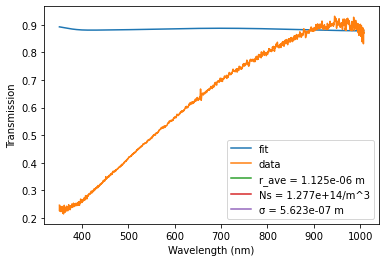

In [88]:
modelfit = newmodel(wavl,*popt)
plt.plot(wavl*1e9,modelfit,label='fit')
plt.plot(wavl*1e9,tr,label='data')
plt.plot([],[],label='r_ave = {:.3e} m'.format(popt[0]))
plt.plot([],[],label='Ns = {:.3e}/m^3'.format(popt[1]))
plt.plot([],[],label='σ = {:.3e} m'.format(popt[2]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
corr = np.corrcoef(tr,modelfit)[0,1]
MSE = sum((modelfit-tr)**2)/len(tr)
print(corr,corr**2,MSE,MSE**0.5)

The fit was not very good. I might be able to get a better fit by starting with the $r$ and $N_s$ values that I already got from the Model1A fit. I will vary σ and see how the graph changes.

Text(0, 0.5, 'Transmission')

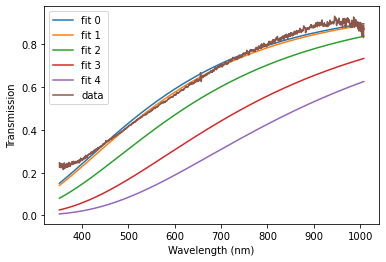

In [94]:
# Best fit parameters from Model1A
r = 1.307e-7
Ns = 1.082e18

# I will plot five different curves, based on different values for σ
newfit0 = newmodel(wavl,r,Ns,0)
newfit1 = newmodel(wavl,r,Ns,1e-8)
newfit2 = newmodel(wavl,r,Ns,3e-8)
newfit3 = newmodel(wavl,r,Ns,5e-8)
newfit4 = newmodel(wavl,r,Ns,6.5e-8)
plt.plot(wavl*1e9,newfit0,label='fit 0')
plt.plot(wavl*1e9,newfit1,label='fit 1')
plt.plot(wavl*1e9,newfit2,label='fit 2')
plt.plot(wavl*1e9,newfit3,label='fit 3')
plt.plot(wavl*1e9,newfit4,label='fit 4')
plt.plot(wavl*1e9,tr,label='data')
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")

The fit with σ = 0 corresponds to the original Model1A fit, which is why it fits the data best. As $\sigma$ gets larger, the value of transmission decreases. This tells us that, for the given values of $\lambda_0$, $N_s$, and the parameters that are fixed by the model, transmission is a concave function of $r$.

In [97]:
popt = curve_fit(newmodel,wavl,tr,[r,Ns,1e-8])[0]

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in sqrt
  if sys.path[0] == '':
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in sqrt
  app.launch_new_instance()
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in sqrt
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:45: RuntimeWarning: invalid value encountered in true_divide
C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:52: RuntimeWarning: invalid value encountered in tr

0.9943782530972063 0.9887881102326517 0.0005572812903112963 0.023606806016725268


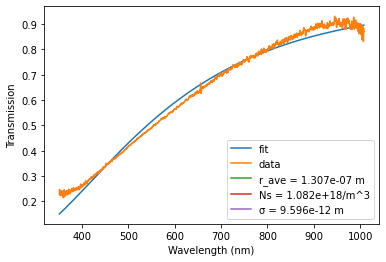

In [98]:
modelfit = newmodel(wavl,*popt)
plt.plot(wavl*1e9,modelfit,label='fit')
plt.plot(wavl*1e9,tr,label='data')
plt.plot([],[],label='r_ave = {:.3e} m'.format(popt[0]))
plt.plot([],[],label='Ns = {:.3e}/m^3'.format(popt[1]))
plt.plot([],[],label='σ = {:.3e} m'.format(popt[2]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
corr = np.corrcoef(tr,modelfit)[0,1]
MSE = sum((modelfit-tr)**2)/len(tr)
print(corr,corr**2,MSE,MSE**0.5)

In [101]:
popt = curve_fit(newmodel,wavl,tr,[1e-7,1e18,4.9e-8])[0]

C:\Users\jrnoo\Anaconda\lib\site-packages\ipykernel_launcher.py:3: RuntimeWarning: overflow encountered in exp
  This is separate from the ipykernel package so we can avoid doing imports until


0.9943784998228478 0.9887886009099373 0.0005572812540226221 0.023606805248119072


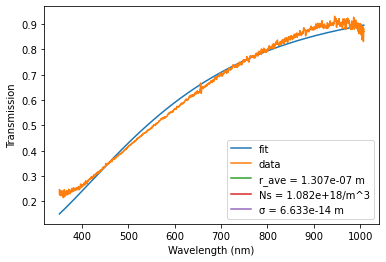

In [102]:
modelfit = newmodel(wavl,*popt)
plt.plot(wavl*1e9,modelfit,label='fit')
plt.plot(wavl*1e9,tr,label='data')
plt.plot([],[],label='r_ave = {:.3e} m'.format(popt[0]))
plt.plot([],[],label='Ns = {:.3e}/m^3'.format(popt[1]))
plt.plot([],[],label='σ = {:.3e} m'.format(popt[2]))
plt.legend()
plt.xlabel("Wavelength (nm)")
plt.ylabel("Transmission")
corr = np.corrcoef(tr,modelfit)[0,1]
MSE = sum((modelfit-tr)**2)/len(tr)
print(corr,corr**2,MSE,MSE**0.5)

The fit still isn't any closer to the data, despite the extra parameter.